# Data Exploration

We will be inspecting the following features of the film industry:

- Budget Allocation
- Genre
- Release Window
- Runtime
- Director

During our exploration we will identify some recommendations for our client.

Our main metric for analysis will be profit margin, as it allows us to compare movies on the same scale. Profit margin is also excellent because it will allow us to
measure the risk associated with the various comparisons we will make.

In [1]:
# ignore warnings
from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(font_scale=1.2)

In [3]:
# load our cleaned data and display head
df = pd.read_csv("../data/interim/cleaned_data.csv", parse_dates=["release_date"])
display(df.head())

,movie,production_budget,profit,profit_margin,release_date,runtime_minutes,genres,director
0,Avatar,5.064591e+08,3.708297e+09,7.322007,2009-12-18,93.0,Horror,Atsushi Wada
1,Pirates of the Caribbean: On Stranger Tides,4.666721e+08,9.957730e+08,2.133774,2011-05-20,136.0,Action,Rob Marshall
2,Pirates of the Caribbean: On Stranger Tides,4.666721e+08,9.957730e+08,2.133774,2011-05-20,136.0,Adventure,Rob Marshall
3,Pirates of the Caribbean: On Stranger Tides,4.666721e+08,9.957730e+08,2.133774,2011-05-20,136.0,Fantasy,Rob Marshall
4,Dark Phoenix,3.500000e+08,-1.574753e+08,-0.449929,2019-06-07,113.0,Action,Simon Kinberg


## Genre

When exploring genre we will be looking to identify which genre clearly is most successful.  
To identify which genre performs the best, we'll be viewing the distribution of profit_margin for each genre.

One thing to note about our data is that movies can have multiple genres. For our analysis we'll allow these duplicates to exist since we can't identify a primary genre.

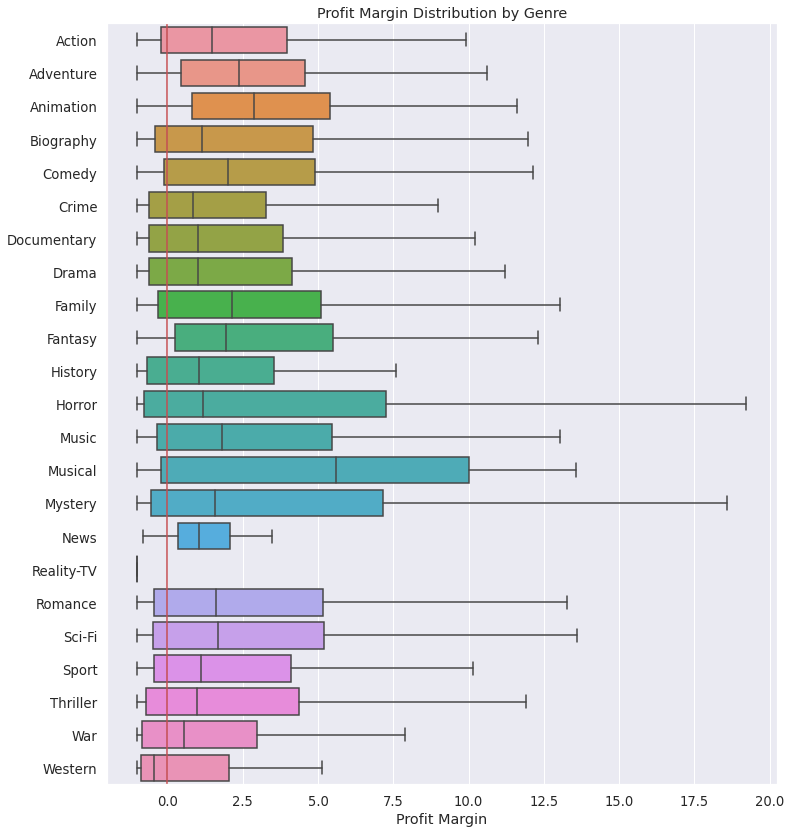

In [4]:
# generate boxplots for each genres profit margin
fig, ax = plt.subplots(figsize=(12, 14))

# make our boxplot
sns.boxplot(
    "profit_margin",
    y="genres",
    data=df,
    ax=ax,
    order=df.genres.sort_values().unique()[:-1],
    showfliers=False,
)

# adjust y axis
locs, _ = plt.yticks()
plt.ylabel("")

# add vertical line
plt.axvline(x=0, ymin=locs[0], ymax=locs[-1], color="r")

# adjust x axis
plt.xlabel("Profit Margin")

# Add title
plt.title("Profit Margin Distribution by Genre")

plt.show()

The boxplot of profit margin by genre, shows us that all genres have risk associated with them. However, there are certain genres which have a lower risk compared to others. We can identify those genres as the ones which don't have the red line intersecting their interquantile range.  
Those genres are:

1. Animation
2. Adventure
3. Fantasy

Of these genres we'll plot the average of profit and try to identify which genre would be best to produce a movie in.

Note: We left off News from the genre list as news isn't something that can be manufactured/produced by a studio necessarily.

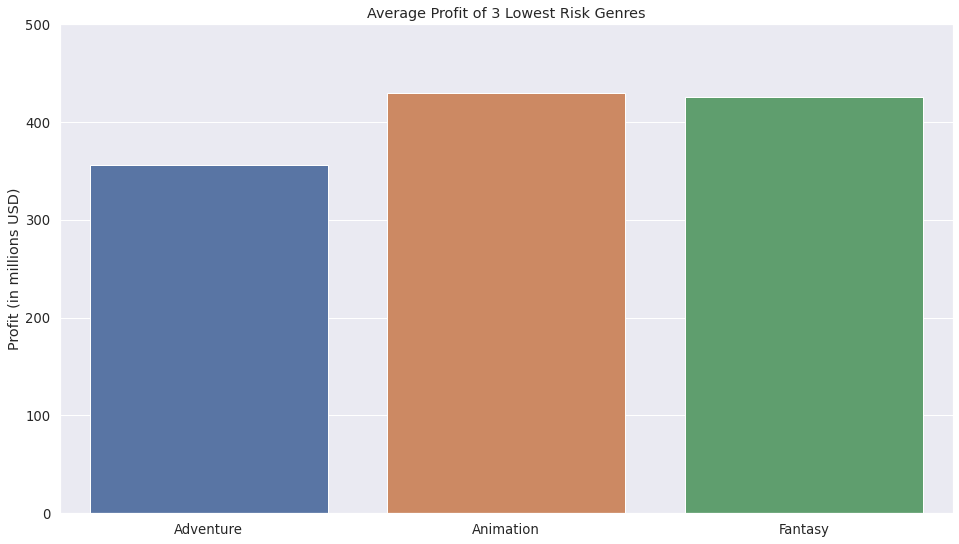

In [5]:
# genres we are interested in
impt_genres = ["Adventure", "Animation", "Fantasy"]
genre_mask = df.genres.isin(impt_genres)

# plot distribution of profit for these genres
fig, ax = plt.subplots(figsize=(16, 9))

sns.barplot(
    x="genres", y="profit", data=df.loc[genre_mask], ax=ax, order=impt_genres, ci=0
)

# adjust y axis
locs, _ = plt.yticks()
plt.yticks(ticks=locs, labels=[f"{i/1_000_000:,g}" for i in locs])

# title and axis labels
plt.title("Average Profit of 3 Lowest Risk Genres")
plt.ylabel("Profit (in millions USD)")
plt.xlabel("")

plt.show()

We can see that Animation not only has the lowest risk associated with it, as measured by it's profit margin distribution. It also ranks the highest in average profit, amongst the 3 low-risk genres. A safe bet for any new movie studio would be to produce an Animation movie.

## Budget Allocation

Next we'll look at the optimal budget allocation for a movie, trying to minimize risk.

- Budget range for all movies
- Budget range for all Animation movies

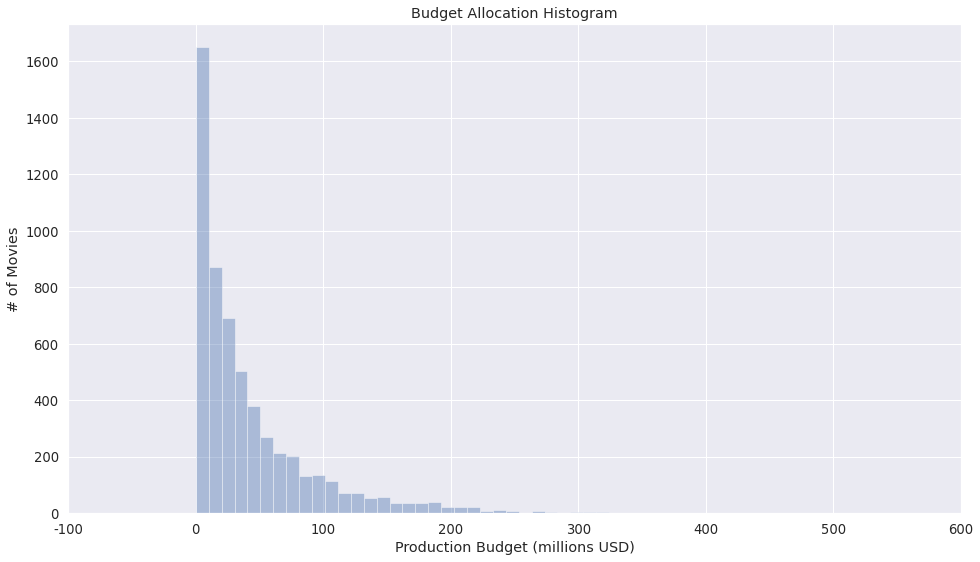

In [6]:
# remove duplicate movies
duplicates_mask = ~df.duplicated("movie")
budget_df = df[duplicates_mask]

# plot production_budget for all movies
fig = plt.figure(figsize=(16, 9))

sns.distplot(budget_df.production_budget, kde=False)

# adjust x axis
locs, _ = plt.xticks()
plt.xticks(ticks=locs, labels=[f"{i/1_000_000:,g}" for i in locs])

plt.ylabel("# of Movies")
plt.xlabel("Production Budget (millions USD)")
plt.title("Budget Allocation Histogram")

plt.show()

We can see that a majority of movies appear to have a budget under 200 million USD, with a few outliers causing a positive skew in our histogram.
The general trend of the histogram is as expected though, we would expect to see more movies on the low budget end of the spectrum than we do on the high end. 

Before moving forward, we'll want to create bins to put our budget in. These resulting ranges will allow us to compare the different groups more easily. We'll want to make sure the same amount of movies are inside each range so we'll use quantiles to separate our budget into 10 equal groups.

In [7]:
# create dataframe with budget binned
bins = np.quantile(budget_df.production_budget, np.linspace(0, 1, 11))
labels = [f"{i/1_000_000:,.0f}" for i in bins[1:]]

budget_df["bin"] = pd.cut(budget_df.production_budget, bins, include_lowest=True, labels=labels)

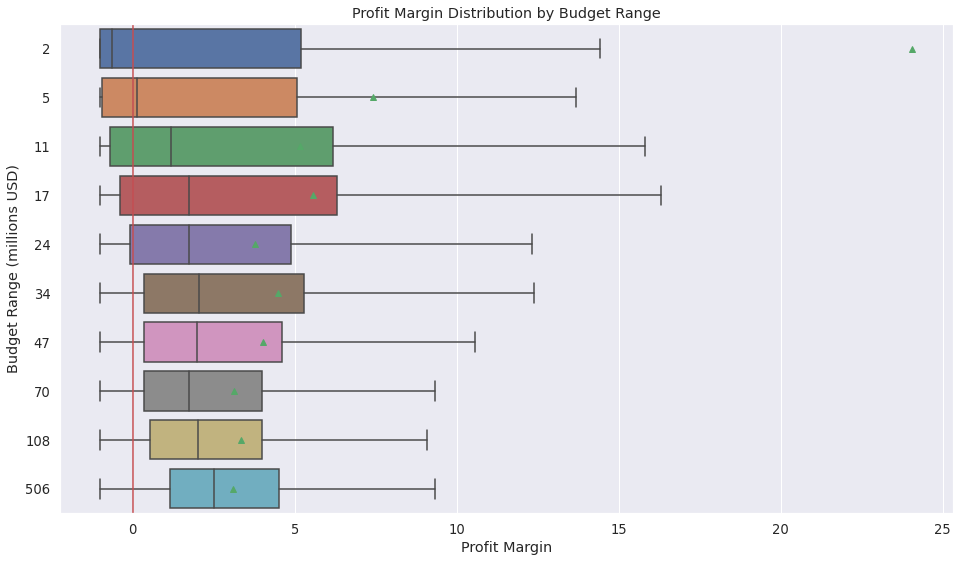

In [8]:
# plot profit margin for each budget range
fig = plt.figure(figsize=(16, 9))

sns.boxplot("profit_margin", "bin", data=budget_df, showfliers=False, showmeans=True)

# plot vertical line
locs, _ = plt.yticks()
plt.axvline(0, locs[0], locs[-1], color="r")


plt.xlabel("Profit Margin")
plt.ylabel("Budget Range (millions USD)")
plt.title("Profit Margin Distribution by Budget Range")


plt.show()

We can see that of the 10 budget ranges we have created, 5 of them perform very well:

- (24, 34]
- (34, 47]
- (47, 70]
- (70, 108]
- (108, 506]


These categories are all multi-million dollar categories, but we can also see that out of the 5, the 24 - 34 million USD range also has a higher average net profit margin. Meaning this category would be an excellent entry level budget range for movies.

In [9]:
# create animation movie dataframe with budget binned into 10 categories
anim_mask = df.genres == "Animation"
anim_df = df[anim_mask]
anim_df = anim_df[~anim_df.duplicated("movie")]

bins = np.quantile(anim_df.production_budget, np.linspace(0, 1, 11))
labels = [f"{i/1_000_000:,.0f}" for i in bins[1:]]

anim_df["bin"] = pd.cut(anim_df.production_budget, bins, include_lowest=True, labels=labels)

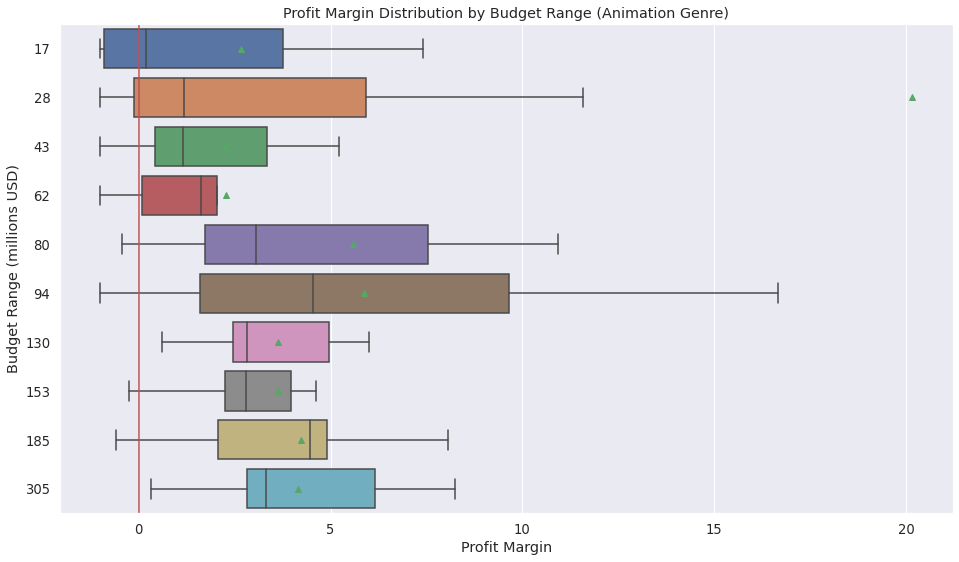

In [10]:
# plot profit margin for each budget range
fig = plt.figure(figsize=(16, 9))

sns.boxplot("profit_margin", "bin", data=anim_df, showfliers=False, showmeans=True)

# plot vertical line
locs, _ = plt.yticks()
plt.axvline(0, locs[0], locs[-1], color="r")


plt.xlabel("Profit Margin")
plt.ylabel("Budget Range (millions USD)")
plt.title("Profit Margin Distribution by Budget Range (Animation Genre)")


plt.show()

Within the Animation genre, we can see that two budget ranges clearly stand out as they aren't intersected by the red line at all.

- (94, 130]
- (185, 305]

All of the animation movies within those budget ranges (according to our data) have returned a profit. Coupled with our previous finding that Animation movies are the best genre to produce, we have now found that the Animation has 2 budget ranges that fair well at box offices. Our recommendation for any budding movie studio would be to produce movies in the 94 - 130 million USD budget range, as the cost is less than the 185 - 305 million USD budget range, yet is still profitable.